# AI4Life Data Prep

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Filtering relevant locations in Austria

In [2]:
submission = open("submission.csv","r")
ids = set(submission.readline().strip().split(",")[1:])
submission.close()
files = os.listdir("Grundwasserstand-Monatsmittel")
for file in files:
    id = file.removeprefix("Grundwasserstand-Monatsmittel-").removesuffix(".csv")
    if (id in ids):
        shutil.copyfile(f"Grundwasserstand-Monatsmittel/Grundwasserstand-Monatsmittel-{id}.csv",f"data/{id}")

### Cleaning data and storing as dataframe

In [3]:
def date_formatter(date_string):
    day,month,year = date_string.split(" ")[0].split(".")
    timestamp = date_string.split(" ")[1]
    return f"{year}.{month}.{day} {timestamp}"

files = os.listdir("data")
dfs = []
for file in files:
    rows = []
    f = open(f"data/{file}","r")
    lines = f.readlines()
    c = 0
    for line in lines:
        c += 1
        if ("Werte:" in line):
            break
    location = file + " " + lines[0].split(";")[1].strip()
    lines = lines[c:]
    for line in lines:
        line = line.strip().split(";")
        date = date_formatter(line[0].strip())
        value = line[1].strip()
        if "L" in value:
            value = "-1"
        row = {"date":date,location:float(value.replace(",","."))}
        rows.append(row)
    aux_df = pd.DataFrame(rows)
    aux_df["date"] = aux_df["date"].astype("datetime64[ns]")
    dfs.append(aux_df)


In [4]:
base_df = pd.DataFrame(columns = ["date"])
for df in dfs:
    base_df = pd.merge(base_df, df, on=["date"],how="outer")
base_df

,date,"300111 Bruck an der Leitha, Br","300137 Bruckneudorf, Br","300236 Ebreichsdorf, Bl 23","300269 Ebreichsdorf, Bl 33","300384 Enzersdorf a.d.Fischa, Bl B","300400 Weikersdorf, Bl 202","300616 Hirtenberg, Br","300665 Lanzenkirchen, Br","300780 Mitterndorf a.d.F., Br (III)",...,"374967 Bergham, Br 53.2","375113 Roitham, Br 58.2","375923 Marchtrenk, Br 25.5","376517 Aschet, Br 31.2","376608 Steyregg, Bl 2126.011","376657 Strass, Br 38.3","376715 Kreisbichl, Bl 41.7","376954 Ansfelden, Bl 8.8","377887 St. Peter, Bl 28.24","379313 Tosters, Bl 01.32.46"
0,1936-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1936-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1936-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1936-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1936-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,2021-09-01,154.31,152.43,195.89,200.10,158.66,271.12,273.56,292.17,188.35,...,354.46,367.30,297.46,311.06,246.57,323.64,330.30,261.88,248.58,437.92
1027,2021-10-01,154.21,152.51,195.91,200.10,158.68,270.79,273.52,291.92,188.34,...,354.21,367.20,297.30,311.07,246.47,323.38,330.03,261.82,248.49,437.19
1028,2021-11-01,154.04,152.45,195.99,200.12,158.70,270.44,273.49,291.66,188.38,...,354.07,367.13,297.14,311.06,246.39,323.25,329.93,261.76,248.46,436.70
1029,2021-12-01,153.93,152.73,196.15,200.16,158.72,270.11,273.48,291.51,188.43,...,354.09,367.31,297.13,311.08,246.37,323.26,330.27,261.79,248.48,436.66


In [5]:
base_df = base_df.replace(-1,None).fillna(value=np.nan)
base_df.to_csv("ordered_data.csv")

C:\Users\samot\AppData\Local\Temp\ipykernel_17944\3115360909.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_df = base_df.replace(-1,None).fillna(value=np.nan)


### Visualizing the time series

In [6]:
import plotly.express as px

fig = px.line(base_df, x="date", y=base_df.columns[3], title='Chart')
fig.show()

Some time series have empty and NULL values. We use linear interpolation.

In [7]:
interpolated_df = base_df.fillna(value=np.nan).interpolate("linear",limit_direction="both")

In [8]:
base = 60
fig = px.line(interpolated_df, x="date", y=interpolated_df.columns[base:base + 10], title='Groundwater levls for a set of locations in Austria')
fig.show()

Some regions have high variance and others don't change much at all.

In [9]:
region_variances = interpolated_df[interpolated_df.columns[3:]].var()
region_variances = region_variances.sort_values(ascending=False)
region_variances

335877 Gattendorf, Bl 55               23.288515
301937 Wr.Neustadt-Neuwirtsh. Br        5.536496
326975 Lanzenkirchen, Bl 300            4.511125
313643 Wr.Neustadt, Br 10               3.200781
324434 Heiligenstatt, Bl 34.4           2.826627
                                         ...    
326264 Schützen am Gebirge, Br 21       0.004113
345710 Neustift a.d. Lafnitz, Bl 30     0.003619
300384 Enzersdorf a.d.Fischa, Bl B      0.003515
335604 Markt Allhau, Bl 15              0.002299
376517 Aschet, Br 31.2                  0.002052
Length: 485, dtype: float64

In [10]:
top_variance_regions = region_variances[0:3]
bot_variance_regions = region_variances[-3:]

In [11]:
fig = px.line(interpolated_df, x="date", y=top_variance_regions.index, title='Groundwater level for highest variance regions')
fig.show()

In [12]:
fig = px.line(interpolated_df, x="date", y=bot_variance_regions.index, title='Groundwater level for lowest variance regions')
fig.show()

### A predictive model for a high variance region: Lanzenkirchen, BI 300.

In [13]:
data = interpolated_df[["date", "326975 Lanzenkirchen, Bl 300"]]
data.columns = ["date","height"]
data

,date,height
0,1936-01-01,276.39
1,1936-02-01,276.39
2,1936-03-01,276.39
3,1936-04-01,276.39
4,1936-05-01,276.39
...,...,...
1026,2021-09-01,277.64
1027,2021-10-01,276.59
1028,2021-11-01,276.34
1029,2021-12-01,276.24


In [14]:
fig = px.line(data, x="date", y="height", title='Depth of ground water level at Lanzenkirchen, Austria')
fig.show()

The reading starts at 1984. We truncate.

In [15]:
truncated_data = data.iloc[data.index[data["date"] == "1 1984"][0]:]
fig = px.line(truncated_data, x=truncated_data["date"], y=truncated_data["height"], title='Depth of ground water level at Lanzenkirchen, Austria')
fig.show()

We'll split the data into 80/20 train/test sets.

In [16]:
train_size = int(truncated_data.shape[0] * 0.7)

In [17]:
train = truncated_data.iloc[0:train_size]
test = truncated_data.iloc[train_size:]    
print(train.shape,test.shape)

(322, 2) (138, 2)


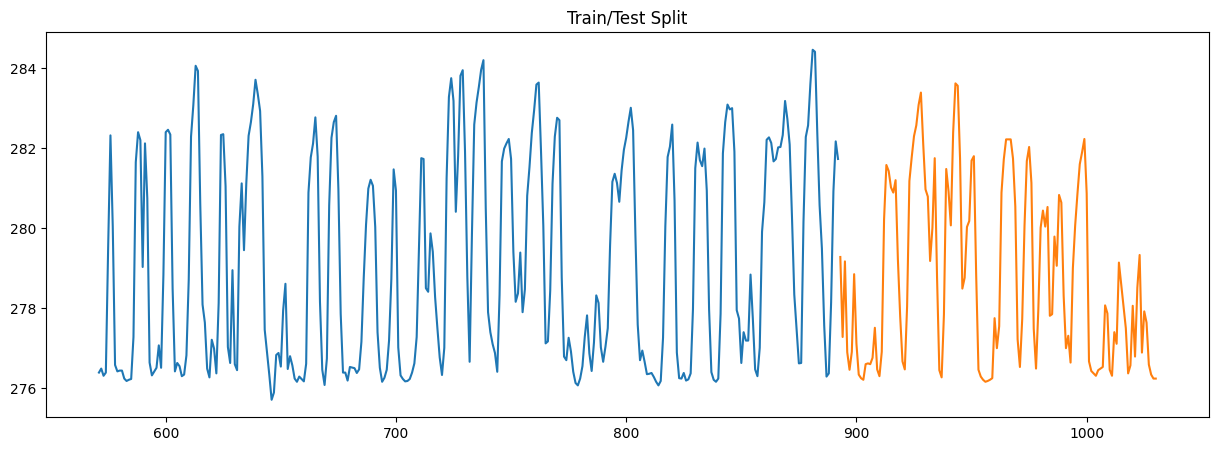

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
train["height"].plot(ax=ax, label = "Training Set", title= "Train/Test Split")
test["height"].plot(ax=ax, label = "Test Set")
plt.show()

### A simple LSTM model

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import optimizers
from sklearn.preprocessing import StandardScaler

In [20]:
def create_sequences(data, sequence_length):
    data = np.array(data)
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

scaler = StandardScaler()
train_data = scaler.fit_transform(np.array(train["height"]).reshape(-1,1))
test_data = scaler.transform(np.array(test["height"]).reshape(-1,1))

sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)


In [25]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(sequence_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error')

model.fit(X_train, y_train, epochs=500, batch_size=32)

Epoch 1/500


c:\Users\samot\Desktop\AI4Life\Water-Level-Prediction\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0813
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9437 
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9145 
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8398 
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7216 
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6799 
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6086 
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4827 
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3891 
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3267 
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3401 
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3324 
Epoch 13/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2884 
Epoch 14/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2825 
Epoch 15/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2775 
Ep

### We attempt to extrapolate to the validation set using only forecasted values

In [95]:
forecast

[1.2444309325808365,
 0.5573120100989428,
 0.14504065660981533,
 -0.5878861940375394,
 -1.0765040944690947,
 -1.045965475692128,
 -0.3702985352516104,
 0.6909184672482078,
 1.1680843856384087,
 1.000121982365059]

In [96]:
train_data[-10:]

array([[ 1.24443093],
       [ 0.55731201],
       [ 0.14504066],
       [-0.58788619],
       [-1.07650409],
       [-1.04596548],
       [-0.37029854],
       [ 0.69091847],
       [ 1.16808439],
       [ 1.00012198]])

In [98]:
forecast = train_data[-sequence_length:]
test_size = truncated_data.shape[0] - train_size
for i in range(test_size):
    shaped_input = np.expand_dims(forecast[-sequence_length:],0)
    np.append(forecast,model.predict(shaped_input)[0])
    break
forecast

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [91]:
shaped_input = np.expand_dims(train_data[1:11],0)
p = model.predict(shaped_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[-1.0703046]], dtype=float32)

In [26]:
preds = scaler.inverse_transform(predictions)
full_preds = list(test["height"])[0:sequence_length] + list([p[0] for p in preds])
preds_df = test.copy(deep=False)
preds_df["height"] = full_preds


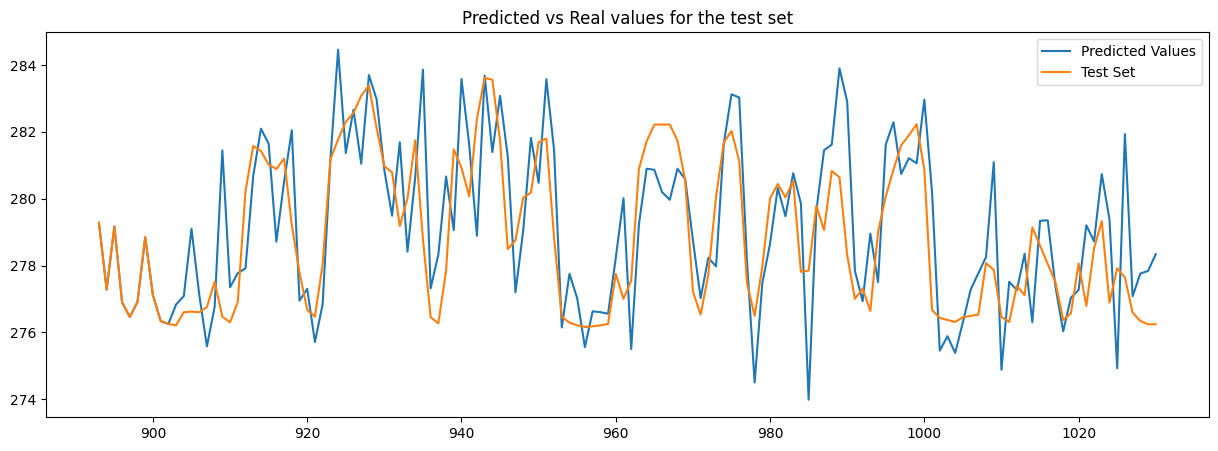

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
preds_df["height"].plot(ax=ax, label="Predicted Values", title="Predicted vs Real values for the test set")
test["height"].plot(ax=ax, label="Test Set")
plt.legend()
plt.show()

### Feature Engineering

To capture seasonality and other characteristics of the data, we construct a few artificial features

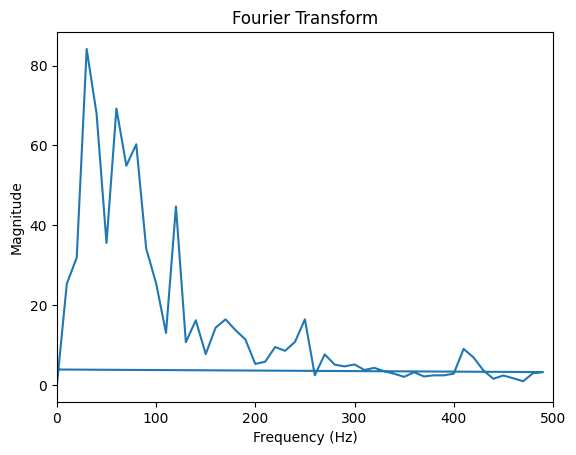

In [24]:
heights = np.array(train["height"])[200:300]
normalized_heights = heights - heights.mean()

fourier_transform = np.fft.fft(normalized_heights)
sample_rate = 1000

# Compute the corresponding frequencies
frequencies = np.fft.fftfreq(len(fourier_transform), 1 / sample_rate)

# Plot the magnitude of the Fourier Transform
plt.plot(frequencies, np.abs(fourier_transform))
plt.title("Fourier Transform")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, sample_rate/2)  # Plot only positive frequencies
plt.show()